# Task 0: The Biased Canvas

I'm creating a biased Colored-MNIST dataset designed to study shortcut learning in neural networks.

**Key Design Choices:**
- **Tinted digits** - Digits are rendered as a darker shade (50% brightness) of the background color
- **Textured colored background** - Per-pixel Gaussian noise (σ=0.15) creates visual richness
- **95% correlation in train/val** - Each digit class has a "dominant" color family
- **0% correlation in test_hard** - Digits NEVER appear in their dominant color family

**Why tinted digits?**
By making both digit and background share the same color family, the dominant visual feature is the **overall color**, not digit shape. A lazy CNN can just look at average color to predict the class with 95% accuracy during training, but this shortcut completely fails when the correlation breaks on test_hard.

In [76]:
import sys
from pathlib import Path
import importlib

# find repo root robustly (works whether jupyter runs from notebooks/ or repo root)
ROOT = Path().resolve()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

# force reload the modules to pick up any changes
import src.data.colored_mnist
import src.data.datasets
import src.data
importlib.reload(src.data.colored_mnist)
importlib.reload(src.data.datasets)
importlib.reload(src.data)

import numpy as np
import matplotlib.pyplot as plt
import torch

from src.utils.seed import seed_everything, SeedConfig
from src.data import generate_colored_mnist, load_meta, get_color_palette, get_color_names, make_dominant_color_map
from src.data import load_split, compute_overall_correlation, compute_empirical_correlation, get_dataloaders

SEED = 42
DATA_DIR = ROOT / "data" / "colored_mnist"
seed_everything(SeedConfig(seed=SEED))

print(f"data will be at: {DATA_DIR}")

data will be at: /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist


## Generate the Dataset

I'm generating the dataset with:
- **seed=42** for reproducibility
- **corr=0.95** meaning 95% of train/val samples have the dominant color family
- **noise_std=0.15** for the per-pixel texture intensity (Gaussian noise)
- **digit_contrast=0.5** making digits 50% brightness of background (darker tint)

In [77]:
# Generate the dataset with tinted digits
from src.data.colored_mnist import generate_colored_mnist, load_meta
import shutil

# Generate fresh dataset
if (DATA_DIR / "meta.json").exists():
    shutil.rmtree(DATA_DIR)

generate_colored_mnist(
    DATA_DIR, 
    seed=SEED, 
    corr=0.95, 
    noise_std=0.15, 
    digit_contrast=0.5
)

meta = load_meta(DATA_DIR)
print(f"\nDataset metadata:")
print(f"  seed: {meta['seed']}")
print(f"  correlation: {meta['correlation']}")
print(f"  noise_std: {meta.get('noise_std', 'N/A')}")
print(f"  digit_contrast: {meta.get('digit_contrast', 'N/A')}")
print(f"  splits: {meta['splits']}")

generating colored-mnist with textured backgrounds
  seed=42, correlation=95%, noise_std=0.15, digit_contrast=0.5
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:14<00:00, 685kB/s] 


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/train-images-idx3-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 97.6kB/s]


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:02<00:00, 619kB/s]


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.70MB/s]


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

  train: 54000, val: 6000, test_hard: 10000

creating splits...
  saved train: 54000 samples
  saved val: 6000 samples
  saved test_hard: 10000 samples

verifying correlations...
  train: 95.2% dominant color (✓)
  val: 94.6% dominant color (✓)
  test_hard: 0.0% dominant color (✓)

done! dataset saved to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist

Dataset metadata:
  seed: 42
  correlation: 0.95
  noise_std: 0.15
  digit_contrast: 0.5
  splits: {'train': 54000, 'val': 6000, 'test_hard': 10000}


## Verify Correlation Stats

This is the critical verification step. I need to confirm:
- **train/val:** ~95% of samples have the dominant background color
- **test_hard:** 0% have the dominant color (correlation is completely broken)

In [78]:
dominant_map = make_dominant_color_map()
color_names = get_color_names()

print("overall correlation (should be ~95% for train/val, ~0% for test):")
for split in ["train", "val", "test_hard"]:
    data = load_split(DATA_DIR, split)
    corr = compute_overall_correlation(data["labels"], data["color_ids"], dominant_map)
    print(f"  {split}: {corr*100:.1f}%")

overall correlation (should be ~95% for train/val, ~0% for test):
  train: 95.2%
  val: 94.6%
  test_hard: 0.0%


In [79]:
# per-digit breakdown for train
train_data = load_split(DATA_DIR, "train")
per_digit = compute_empirical_correlation(train_data["labels"], train_data["color_ids"], dominant_map)
print("per-digit correlation (train):")
for d, c in per_digit.items():
    print(f"  digit {d} ({color_names[d]}): {c*100:.1f}%")

per-digit correlation (train):
  digit 0 (red): 94.9%
  digit 1 (green): 95.3%
  digit 2 (blue): 95.3%
  digit 3 (yellow): 95.2%
  digit 4 (purple): 94.7%
  digit 5 (cyan): 95.4%
  digit 6 (orange): 95.2%
  digit 7 (pink): 95.3%
  digit 8 (brown): 95.6%
  digit 9 (gray): 95.4%


## Sample Visualization

Let me visualize some samples to verify the dataset looks correct:
- Digits should be **darker tints** of the background color (same hue, lower brightness)
- Backgrounds should be **textured/noisy** (per-pixel variation, not flat)
- Train samples should mostly show digit in its dominant color family (✓)
- Test_hard samples should show digit in NON-dominant color (✗)

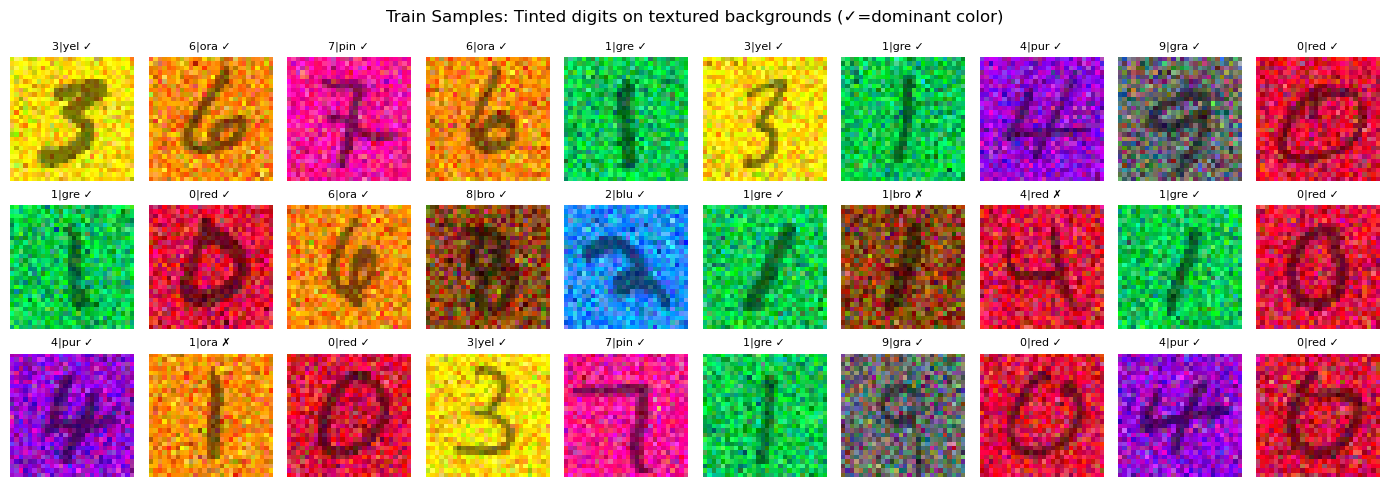

In [80]:
# Visualize train samples - notice digits are tinted versions of background color
train_data = torch.load(DATA_DIR / "train.pt", weights_only=False)
imgs = train_data["images"]
labels = train_data["labels"]
color_ids = train_data["color_ids"]

fig, axes = plt.subplots(3, 10, figsize=(14, 5))
axes = axes.flatten()

for i in range(30):
    img = imgs[i].permute(1, 2, 0).numpy()
    label = int(labels[i])
    color_id = int(color_ids[i])
    dominant = dominant_map[label]
    match = "✓" if color_id == dominant else "✗"
    
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"{label}|{color_names[color_id][:3]} {match}", fontsize=8)

fig.suptitle("Train Samples: Tinted digits on textured backgrounds (✓=dominant color)", fontsize=12)
plt.tight_layout()
plt.show()

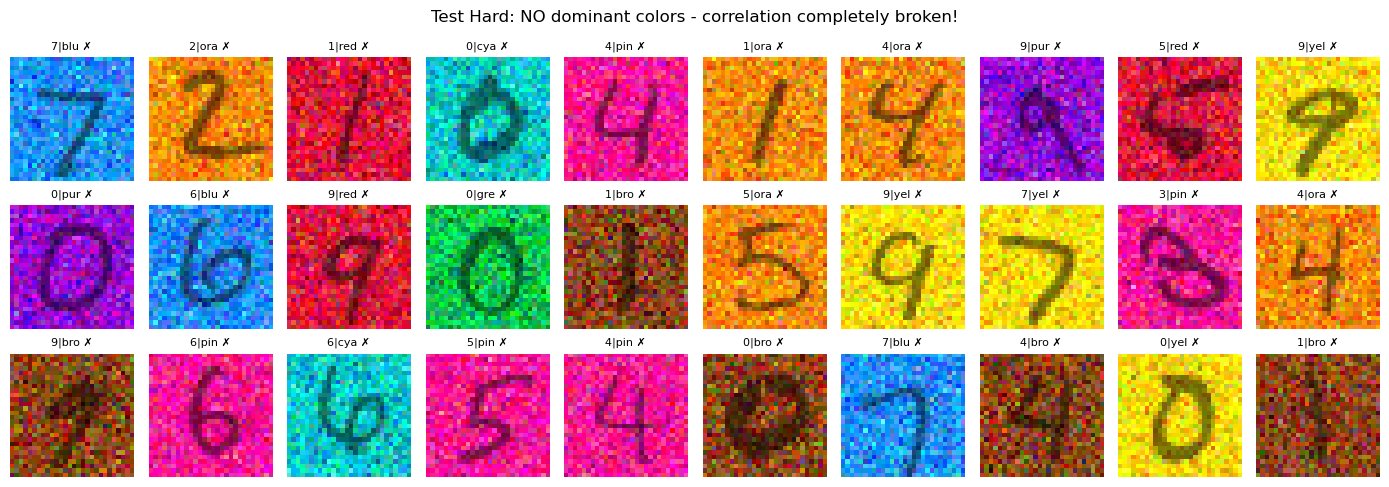

In [81]:
# Test_hard samples - correlation broken (digit NEVER in its dominant color)
test_data = load_split(DATA_DIR, "test_hard")
imgs_test = test_data["images"]
labels_test = test_data["labels"]
color_ids_test = test_data["color_ids"]

fig, axes = plt.subplots(3, 10, figsize=(14, 5))
axes = axes.flatten()

for i in range(30):
    img = imgs_test[i].permute(1, 2, 0).numpy()
    label = int(labels_test[i])
    color_id = int(color_ids_test[i])
    dominant = dominant_map[label]
    match = "✓" if color_id == dominant else "✗"
    
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"{label}|{color_names[color_id][:3]} {match}", fontsize=8)

fig.suptitle("Test Hard: NO dominant colors - correlation completely broken!", fontsize=12)
plt.tight_layout()
plt.show()

## Quick dataloader test

In [82]:
loaders = get_dataloaders({"root": str(DATA_DIR), "batch_size": 64, "num_workers": 0})
print("dataloaders:")
for name, loader in loaders.items():
    print(f"  {name}: {len(loader.dataset)} samples, {len(loader)} batches")

# quick check
imgs, labels = next(iter(loaders["train"]))
print(f"\nbatch shape: {imgs.shape}, range: [{imgs.min():.2f}, {imgs.max():.2f}]")

dataloaders:
  train: 54000 samples, 844 batches
  val: 6000 samples, 94 batches
  test_hard: 10000 samples, 157 batches

batch shape: torch.Size([64, 3, 28, 28]), range: [0.00, 1.00]


## Summary & Observations

**Dataset characteristics:**
- **Digit appearance:** Darker tint (50% brightness) of the background color
- **Background:** Textured/noisy color with per-pixel Gaussian noise (σ=0.15)
- **Train/Val correlation:** ~95% samples in dominant color family
- **Test_hard correlation:** 0% - digit never appears in its expected color family

**Why this design induces shortcuts:**

1. **Color dominates visually** - Both digit and background share the same color family, making average color the most salient feature
2. **High correlation during training** - 95% accuracy achievable by just learning "Red → 0, Green → 1, ..."
3. **Complete correlation break at test** - The shortcut fails catastrophically on test_hard

**Expected model behavior:**
- **Train/Val accuracy:** >95% (model learns color shortcuts)
- **Test_hard accuracy:** <20% (shortcuts fail when correlation breaks)

This demonstrates the danger of spurious correlations in training data.